# MSDS 422-57 Assignment 5- Prerak, Mehta

## Introduction / Summary

The goal of this assignment is to build a predictive model that will recognize hand written digits from 0 through 9. The pixel data of more than 40 thousand images of different hand written numbers from 0 to 9 is provided. We will use this pixel data to train a random forest predictive model. Principal component analysis (PCA) will also be looked upon to see if it has any postive effect on the random forest model. 

In [193]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle   
import sys
import os
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [194]:
with open('assign-5-train.pickle','rb') as inFile:
    digitsData=pickle.load(inFile)

In [195]:
#Should be true if the Data is a pd DataFrame.
print(isinstance(digitsData,pd.DataFrame))   
#information on the shape of the dataset
print(digitsData.shape)
#Columns in the dataset that provide feature information that will be useful in modeling
print(digitsData.columns)


True
(41179, 786)
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'imageNum'],
      dtype='object', length=786)


In [184]:
print(digitsData.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      6       0       0       0       0       0       0       0       0   
1      6       0       0       0       0       0       0       0       0   
2      5       0       0       0       0       0       0       0       0   
3      9       0       0       0       0       0       0       0       0   
4      9       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  imageNum  
0         0         0         

In [197]:
X = digitsData.iloc[:, 1:-1].values
y = digitsData.iloc[:, 0].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#### Notes 
- There are two types of models we will build in the assignment. 1) RF Classifier without pca and 2) RF classifier using PCA.
- The RF classifier will model will be trained with a limit on n_estimators and and max_features since the data is too large. GridSearchCV will be used to find out the correct value for hyperparameter max_depth since that would directly affect our RF classifier model.
- We will evaluate our RF regression model using K fold cross validation method and retrieve the accuracy, R^2, MSE, and response variance on both training and test sets in order to see how well our model performs.
- For the second model, we will use the pca class from sklearn library and first find out the number of components that account for 80% of the variation in the pixel features and by doing so we will reduce the training pixel data using PCA.
- Now using the reduced pizel training data we will validate another RF classifier but this time after applying PCA.
- We will use k fold cross validation method and previously mentioned performance metrics to validate and check the performance of this model.
- We will time the time it took to train and validate both of our models. Using the better performance model we will predict the values from the test pickle file.
- We will take care of data leakage throughout the training and PCA application parts by making sure we do not fit our models on the test data and only transform them as that will give our model false accuracy. 

## Random Forest Classifier

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [222]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler=preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [224]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy' ,random_state = 0, 
                                    max_features = 'sqrt', bootstrap = True)

from sklearn.model_selection import GridSearchCV
parametersmf = [{'max_depth':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]}]
searchmf = GridSearchCV(estimator = classifier, param_grid = parametersmf, cv = 5)
searchmf.fit(X_train, y_train)

best_accuracy = searchmf.best_score_
best_parameters = searchmf.best_params_
print('Best Accuracy of RF classifier: ', best_accuracy)
print('Best max_depth parameter for RF classifier model: ', best_parameters)

Best Accuracy of RF classifier:  0.9364053149980516
Best max_depth parameter for RF classifier model:  {'max_depth': 18}


##### We notice the best accuracy of our RF classifier model is achieved at max_depth = 18. We will use that hyperparameter value to train and validate our RF classifier model.

In [229]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.base import clone
skf = StratifiedKFold(n_splits=40, random_state=99,shuffle=True) 
scaler=preprocessing.MinMaxScaler()
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',
                                    max_depth = 18 ,random_state = 0, max_features = 'sqrt', bootstrap = True)

In [230]:
import time
start_time = time.time()

from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix, accuracy_score

hold_rf = [] 

for train_ndx, test_ndx in skf.split(X, y):
    resDict={}
    clone_rf = clone(classifier)
    X_trainS=scaler.fit_transform(X[train_ndx])
    y_train = y[train_ndx]
    X_testS=scaler.transform(X[test_ndx])
    y_test = y[test_ndx]

    foldfitrf=clone_rf.fit(X_trainS, y_train)

    y_pred_test_rf=foldfitrf.predict(X_testS)
    y_pred_train_rf=foldfitrf.predict(X_trainS)
    
    trainAcc_rf=accuracy_score(y_train,y_pred_train_rf)
    testAcc_rf=accuracy_score(y_test,y_pred_test_rf)
    trainR2=r2_score(y_train,y_pred_train_rf)
    trainMSE=mean_squared_error(y_train,y_pred_train_rf)
    testR2=r2_score(y_test,y_pred_test_rf)
    testMSE=mean_squared_error(y_test,y_pred_test_rf)
    df1 = pd.DataFrame(y_pred_test_rf,columns = ['predict'])
    df2 = pd.DataFrame(y_test, columns =['test'])
    RV_test = round(np.power(df2['test'].corr(df1['predict']),2),3)
    df3 = pd.DataFrame(y_pred_train_rf,columns = ['predict'])
    df4 = pd.DataFrame(y_train, columns =['train'])
    RV_train = round(np.power(df4['train'].corr(df3['predict']),2),3)

    resDict.update({'train_accuracy':trainAcc_rf,
                    'test_accuracy':testAcc_rf,
                    'trainR2':trainR2,
                    'testR2':testR2,
                    'trainMSE':trainMSE,
                    'testMSE':testMSE,
                    'Response_Variance_Train':RV_train,
                    'Response_Variance_Test':RV_test                    
                   })
    hold_rf.append(resDict)    

print(" %s seconds taken to train and validate RF classifier model" % (time.time() - start_time))

 145.18543982505798 seconds taken to train and validate RF classifier model


In [231]:
cvresDF=pd.DataFrame(hold_rf)[['train_accuracy','test_accuracy','trainMSE','testMSE','trainR2','testR2',
                               'Response_Variance_Train','Response_Variance_Test']]

print('Result description of K Folds method using Random Forest Classifier:\n' , cvresDF.describe())


Result description of K Folds method using Random Forest Classifier:
        train_accuracy  test_accuracy   trainMSE    testMSE    trainR2  \
count       40.000000      40.000000  40.000000  40.000000  40.000000   
mean         0.998907       0.941669   0.021548   1.019840   0.997417   
std          0.000187       0.007340   0.004436   0.184397   0.000532   
min          0.998456       0.920311   0.014023   0.664723   0.996252   
25%          0.998780       0.936878   0.018007   0.909685   0.997041   
50%          0.998929       0.942663   0.021096   0.998543   0.997471   
75%          0.999035       0.946550   0.024683   1.132561   0.997841   
max          0.999253       0.957240   0.031258   1.458698   0.998319   

          testR2  Response_Variance_Train  Response_Variance_Test  
count  40.000000                40.000000               40.000000  
mean    0.877726                 0.997400                0.881950  
std     0.022131                 0.000632                0.020599  


In [235]:
# Visualize a confusion matrix for the RF Classifier model.
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy Score', accuracy_score(y_test, y_pred))

[[791   0   3   1   2   5   8   0   2   0]
 [  0 887   4   2   1   0   1   2   3   0]
 [  2   5 783  10   2   4   2  10   6   1]
 [  6   2  16 784   3  19   0   4  19   6]
 [  3   1   3   0 725   2   2   3   1  23]
 [  8   3   0  31   3 704   8   1   9   7]
 [  9   4   1   3   4  13 806   0   3   0]
 [  1   6  14   2  11   2   0 790   3  14]
 [  4   7  16  16   9  13   6   3 731   9]
 [  2   1   3  16  25   9   4  10   7 726]]
Accuracy Score 0.9381981544439048


The accuracy we received is close to the accuracy mean of the test set from the cross validation evaluation so that's good.

## Principal Component Analysis (PCA)

Firstly we shalle find the number of components that account for 80% of the variation in the pixel features.

 4.348626136779785 seconds taken to identify the number of components vs cum explained variance


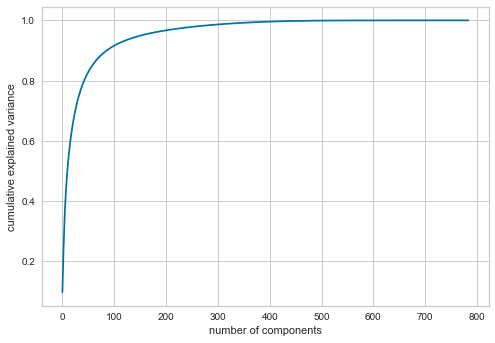

In [237]:
import time
start_time = time.time()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler=preprocessing.MinMaxScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print(" %s seconds taken to identify the number of components vs cum explained variance" % (time.time() - start_time))

Hence 42 should be the count of the principal components going into the next step which is evaluation using k fold cross validation of RF classifier after applying PCA.

In [243]:
import time
start_time = time.time()

from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix, accuracy_score

hold_rf = [] 

pca = PCA(n_components = 42)
classifierpca = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth = 18 ,
                                       random_state = 0, max_features = 'sqrt', bootstrap = True)

skf = StratifiedKFold(n_splits=40, random_state=99,shuffle=True) 
scaler=preprocessing.MinMaxScaler()

for train_ndx, test_ndx in skf.split(X, y):
    resDict={}
    clone_rf = clone(classifierpca)
    X_trainS=scaler.fit_transform(X[train_ndx])
    y_train = y[train_ndx]
    X_testS=scaler.transform(X[test_ndx])
    y_test = y[test_ndx]
    
    X_train_pca = pca.fit_transform(X_trainS)
    X_test_pca = pca.transform(X_testS)
    
    foldfitrf=clone_rf.fit(X_train_pca, y_train)

    y_pred_test_rf=foldfitrf.predict(X_test_pca)
    y_pred_train_rf=foldfitrf.predict(X_train_pca)
    
    trainAcc_rf=accuracy_score(y_train,y_pred_train_rf)
    testAcc_rf=accuracy_score(y_test,y_pred_test_rf)
    trainR2=r2_score(y_train,y_pred_train_rf)
    trainMSE=mean_squared_error(y_train,y_pred_train_rf)
    testR2=r2_score(y_test,y_pred_test_rf)
    testMSE=mean_squared_error(y_test,y_pred_test_rf)
    df1 = pd.DataFrame(y_pred_test_rf,columns = ['predict'])
    df2 = pd.DataFrame(y_test, columns =['test'])
    RV_test = round(np.power(df2['test'].corr(df1['predict']),2),3)
    df3 = pd.DataFrame(y_pred_train_rf,columns = ['predict'])
    df4 = pd.DataFrame(y_train, columns =['train'])
    RV_train = round(np.power(df4['train'].corr(df3['predict']),2),3)

    resDict.update({'train_accuracy':trainAcc_rf,
                    'test_accuracy':testAcc_rf,
                    'trainR2':trainR2,
                    'testR2':testR2,
                    'trainMSE':trainMSE,
                    'testMSE':testMSE,
                    'Response_Variance_Train':RV_train,
                    'Response_Variance_Test':RV_test                    
                   })
    hold_rf.append(resDict)    
print(" %s seconds taken to identify the train and validate RF classifier model after applying PCA" 
      % (time.time() - start_time))    
#print('K Folds method using Random Forest Classifier')
#pd.DataFrame(hold_rf)[['train_accuracy','test_accuracy']].describe()


 291.36042380332947 seconds taken to identify the train and validate RF classifier model after applying PCA


In [244]:
cvresDF=pd.DataFrame(hold_rf)[['train_accuracy','test_accuracy','trainMSE','testMSE',
                               'trainR2','testR2','Response_Variance_Train','Response_Variance_Test']]

print('Result description of K Folds method using Random Forest Classifier and PCA:\n' , cvresDF.describe())

Result description of K Folds method using Random Forest Classifier and PCA:
        train_accuracy  test_accuracy   trainMSE    testMSE    trainR2  \
count       40.000000      40.000000  40.000000  40.000000  40.000000   
mean         0.998694       0.917338   0.024118   1.415451   0.997108   
std          0.000155       0.009059   0.004273   0.220907   0.000512   
min          0.998356       0.898058   0.015891   1.052478   0.995990   
25%          0.998580       0.912536   0.020891   1.254430   0.996744   
50%          0.998717       0.917436   0.024259   1.382228   0.997092   
75%          0.998804       0.924459   0.027155   1.604713   0.997495   
max          0.999004       0.933916   0.033450   1.857282   0.998095   

          testR2  Response_Variance_Train  Response_Variance_Test  
count  40.000000                40.000000               40.000000  
mean    0.830292                 0.997125                0.837750  
std     0.026535                 0.000607                0.0

//anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


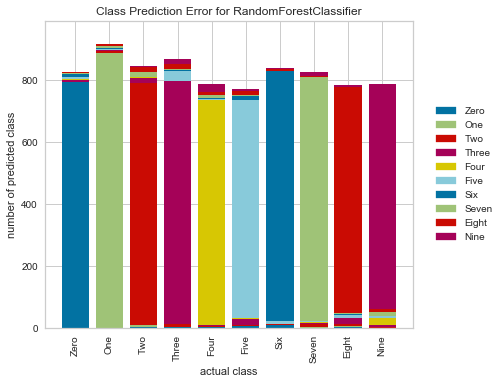

In [246]:
#CREDIT AND REFERENCE KAREN O'BRIEN who posted this visualization in the assignment huddle.  

from yellowbrick.classifier import ClassPredictionError

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth = 18 ,
                                    random_state = 0, max_features = 'sqrt', bootstrap = True)

classes =["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
colors = ["blue", "green", "black", "red", "yellow", "orange", "steelblue", "darkgray", "pink", "silver"]

visualizer = ClassPredictionError(classifier, classes=classes)
visualizer.fit(X_train, y_train)

visualizer.score(X_test, y_test)

visualizer.show();

##### Hence we see the Random Forest Classifier with application of PCA analysis, in this case, provides more accuracy and on top of that a better overall accuracy and less error. Hence We will use this model to predict labels for the test data. We will train and fit the model once again with the suitable hyperparameters once again.

In [240]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

scaler=preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)

classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=18, max_features='sqrt',
                       n_estimators=10, random_state=0)

In [241]:
with open('assign-5-test.pickle','rb') as inFile:
    digitsDataTest=pickle.load(inFile)
    
X_testfinal = digitsDataTest.iloc[:, 1:-1].to_numpy()

y_pred_digit = classifier.predict(X_testfinal)

imageNum = digitsDataTest.iloc[:, -1].values

ar = np.concatenate((imageNum.reshape(len(imageNum),1), y_pred_digit.reshape(len(y_pred_digit),1)),1)

FinalDf = pd.DataFrame(data=ar, columns = ['imageNum','digit'])
FinalDf.rename(columns = {"0":"imageNum","1":"digit"})


,imageNum,digit
0,77,6
1,109,6
2,112,0
3,274,7
4,326,5
...,...,...
816,41842,3
817,41901,7
818,41934,7
819,41995,1


## Export to CSV

In [242]:
FinalDf.to_csv('assign-5-mehta-test.csv')

### Assignment discussion and Conclusion

This assignment took our understanding and application of machine learning models to another level and gives much more confidence going into nueral networks next week. Random Forest is proving to be an extremely powerful machine learning model to get more accurate results in most cases. No wonder WII games used the RF classifier machine learning model to recognize the hand gestures from the players and design an entire video game platform out of it. To my much surprise the utilization of PCA did not yield a better accuracy. This was even after we chose the principal components manually. I believe the regular RF classifier model would have yielded an even better accuracy if we had a powerful machine at our disposal that could use more n_estimators to train the model. 